In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ranksums
from pymoo.core.termination import Termination

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import Sampling
from pymoo.operators.crossover.hux import HUX
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

from joblib import Parallel, delayed

from collections import defaultdict
from joblib import parallel_backend

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

from joblib import Parallel, delayed
from datetime import datetime
import pandas as pd
import numpy as np
import pickle
import os

from imblearn.over_sampling import (
	SMOTE,
	ADASYN,
	BorderlineSMOTE,
)
from imblearn.combine import (
	SMOTETomek,
	SMOTEENN
)
import wandb


# Define pymoo objects

In [23]:
class NSGA_II_Filter(Problem):
	n_neighbours = 5
	def __init__(self, X_train, y_train, X_val, y_val):
		self.X_train = np.ascontiguousarray(X_train)
		self.y_train = np.ascontiguousarray(y_train)
		self.X_val, self.y_val = X_val, y_val
		self.n_instances = X_train.shape[0]
		super().__init__(n_var=self.n_instances, n_obj=2, n_constr=0, xl=0, xu=1, type_var=np.bool_)

	def train(self, instance, x1, y1, x2, y2):
		
		values = {"Inverse ACC": 1, "Inverse AUC": 1}

		if np.sum(instance) >= NSGA_II_Filter.n_neighbours:
			model = KNeighborsClassifier(n_neighbors=NSGA_II_Filter.n_neighbours)
			model.fit(x1[instance], y1[instance])
			y_pred = model.predict(x2)
			values["Inverse AUC"] = 1 - roc_auc_score(y2, y_pred)
			values["Inverse ACC"] = 1 - accuracy_score(y2, y_pred)

		return values
	
	def _evaluate(self, x, out, *args, **kwargs):
		global instance_index
		global do_stop

		with parallel_backend('loky', inner_max_num_threads=1):
		
			results = Parallel(
				n_jobs=-1,
				batch_size=8,               
				mmap_mode='r',              
				prefer='processes'
			)(delayed(self.train)(mask, self.X_train, self.y_train, self.X_val, self.y_val) for mask in x)

		values = []
		for key in results[0]:
			values.append([result[key] for result in results])

		out["F"] = np.column_stack(values)

class DiverseSampling(Sampling):
	def __init__(self):
		super().__init__()
		
	def _do(self, problem, n_samples, **kwargs):
		target_inclusions = np.random.randint(problem.n_var // 3, problem.n_var, n_samples)
		init_pops = []
		for target in target_inclusions:
			array = np.array([1]*target + [0]*(problem.n_var - target))
			np.random.shuffle(array)
			init_pops.append(array)
		init_pops = np.array(init_pops, dtype=np.bool)
	
		return init_pops

# Define cVAE objects

In [ ]:
class ConditionalVAE(nn.Module):
	def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
		super(ConditionalVAE, self).__init__()
		self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
		self.fc_mu = nn.Linear(hidden_dim, latent_dim)
		self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
		self.fc2 = nn.Linear(latent_dim + label_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, input_dim)

	def encode(self, x, y):
		# Concatenate input and label
		x = torch.cat([x, y], dim=1)
		h = torch.relu(self.fc1(x))
		return self.fc_mu(h), self.fc_logvar(h)

	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std

	def decode(self, z, y):
		# Concatenate latent vector and label
		z = torch.cat([z, y], dim=1)
		h = torch.relu(self.fc2(z))
		return self.fc3(h)

	def forward(self, x, y):
		mu, logvar = self.encode(x, y)
		z = self.reparameterize(mu, logvar)
		return self.decode(z, y), mu, logvar

class TabularDataset(Dataset):
	def __init__(self, x_synthetic, x_true):
		self.x = x_synthetic
		self.y = x_true
	def __len__(self):
		return self.x.shape[0]
	def __getitem__(self, ind):
		x = self.x[ind]
		y = self.y[ind]
		return x, y

# Dataset config

In [8]:
with open('data.pickle', 'rb') as fh: data_mapper = pickle.load(fh)
# splits = pd.read_csv('data_splits.csv')
data_key = "0_abalone-17_vs_7-8-9-10"

x_train = data_mapper[data_key]['x_train']
y_train = data_mapper[data_key]['y_train']

x_validation = data_mapper[data_key]['x_validation']
y_validation = data_mapper[data_key]['y_validation']

real_samples = {row.tobytes() for row in x_train}

minority_label = pd.DataFrame(y_train).value_counts().argmin()
minority_indices = np.where(y_train==minority_label)[0]
minority_features = x_train[minority_indices]
minority_labels = y_train[minority_indices]

# data_mapper[data_key]['y_test']

# Algorithmic oversample

In [26]:
sampler_results = []
for sampler in [SMOTE, ADASYN, BorderlineSMOTE, SMOTETomek, SMOTEENN]:
	sampler_results.append(sampler().fit_resample(
		np.concatenate((x_train, x_validation), axis=0), 
		np.concatenate((y_train, y_validation), axis=0)
	))

# cVAE training

In [5]:
class TabularDataset(Dataset):
	def __init__(self, x_synthetic, x_true):
		self.x = x_synthetic
		self.y = x_true
	def __len__(self):
		return self.x.shape[0]
	def __getitem__(self, ind):
		x = self.x[ind]
		y = self.y[ind]
		return x, y

class ConditionalVAE(nn.Module):
	def __init__(self, input_dim, label_dim, latent_dim):
		super(ConditionalVAE, self).__init__()
		hidden_dim = input_dim + input_dim // 2  # Overcomplete expansion

		# Encoder
		self.enc_fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
		self.enc_fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
		self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
		self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

		# Decoder
		self.dec_fc1 = nn.Linear(latent_dim + label_dim, hidden_dim // 2)
		self.dec_fc2 = nn.Linear(hidden_dim // 2, hidden_dim)
		self.dec_fc3 = nn.Linear(hidden_dim, input_dim)

	def encode(self, x, y):
		x = torch.cat([x, y], dim=1)
		h = torch.relu(self.enc_fc1(x))
		h = torch.relu(self.enc_fc2(h))
		return self.fc_mu(h), self.fc_logvar(h)

	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std

	def decode(self, z, y):
		z = torch.cat([z, y], dim=1)
		h = torch.relu(self.dec_fc1(z))
		h = torch.relu(self.dec_fc2(h))
		return self.dec_fc3(h)

	def forward(self, x, y):
		mu, logvar = self.encode(x, y)
		z = self.reparameterize(mu, logvar)
		return self.decode(z, y), mu, logvar

def mask_features(x, min_mask=1, max_mask=3):
	x_masked = x.clone()
	for i in range(x.size(0)):
		mask_count = torch.randint(min_mask, max_mask + 1, (1,)).item()
		mask_indices = torch.randperm(x.size(1))[:mask_count]
		x_masked[i, mask_indices] = 0
	return x_masked

def contrastive_loss(z, y, margin=1.0):
	"""
	z: (batch_size, latent_dim) latent vectors (e.g., mu)
	y: (batch_size,) class labels as integers
	"""
	# Normalize embeddings
	z_norm = nn.functional.normalize(z, p=2, dim=1)
	loss = 0.0
	count = 0
	for i in range(len(z)):
		for j in range(i + 1, len(z)):
			dist = (z_norm[i] - z_norm[j]).pow(2).sum()
			if y[i] == y[j]:
				loss += dist  # pull together
			else:
				loss += nn.functional.relu(margin - torch.sqrt(dist + 1e-8)).pow(2)  # push apart
			count += 1
	return loss / count

def weighted_contrastive_loss(z, y, margin=1.0, w_minority=5.0, w_majority=1.0):
    z_norm = nn.functional.normalize(z, p=2, dim=1)
    loss, count = 0.0, 0
    for i in range(len(z)):
      for j in range(i+1, len(z)):
        dist = (z_norm[i] - z_norm[j]).pow(2).sum()
        same = (y[i]==y[j])
        w = w_minority if y[i]==minority_label else w_majority
        if same:
          loss += w * dist
        else:
          loss += w * nn.functional.relu(margin - torch.sqrt(dist + 1e-8)).pow(2)
        count += 1
    return loss / count

def train(x, y):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	cvae = ConditionalVAE(x[0].shape[0], 1, 3).to(device)

	train_set = TabularDataset(torch.from_numpy(x), torch.from_numpy(y))
	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	optimizer = optim.Adam(cvae.parameters(), lr=lr)

	for epoch in range(epochs):
		cvae.train()
		total_loss = 0
		for batch in train_loader:

			x_batch = batch[0].to(device).float()
			# print("----------------------------")
			# print(x_batch)
			y_batch = batch[1].to(device).float().unsqueeze(1)
			x_batch_masked = mask_features(x_batch)
			# print(x_batch_masked)
			
			recon, mu, logvar = cvae(x_batch_masked, y_batch)
			recon_loss = nn.MSELoss()(recon, x_batch)
			kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

			# cont_loss = contrastive_loss(mu, y_batch.squeeze(), margin=1.0)
			cont_loss = weighted_contrastive_loss(mu, y_batch.squeeze(), margin=1.0)

			loss = recon_loss + beta * kl_div + alpha * cont_loss
		
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			
			total_loss += loss.item()
		if epoch % 5 == 0:
			print(f"Epoch {epoch:>3} Loss: {np.mean(total_loss)}")

	return cvae

def generate_latents(cvae, x, y):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	cvae.eval()
	
	with torch.no_grad():    
		x = torch.from_numpy(x).to(device).float()
		y = torch.from_numpy(y).to(device).float().unsqueeze(1)
		mu, logvar = cvae.encode(x, y)
		z = cvae.reparameterize(mu, logvar)
		minority_latents = z.cpu().numpy()

	return minority_latents

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np


# ---------- Data set ----------
class TabularDataset(Dataset):
    def __init__(self, x_synthetic, x_true):
        self.x = x_synthetic
        self.y = x_true

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# ---------- Over-complete Conditional VAE ----------
class ConditionalVAE(nn.Module):
    """
    Over-complete: hidden layers and latent space wider than (or equal to) input.
    """
    def __init__(self, input_dim: int, label_dim: int, latent_dim: int = 4):
        super().__init__()

        self.latent_dim = latent_dim
        hidden_dim = input_dim * 2            # <-- over-complete width

        # ----- Encoder -----
        self.enc_fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.enc_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # ----- Decoder -----
        self.dec_fc1 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_out = nn.Linear(hidden_dim, input_dim)

    # --------- utilities ---------
    def encode(self, x, y):
        h = torch.relu(self.enc_fc1(torch.cat([x, y], dim=1)))
        h = torch.relu(self.enc_fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h = torch.relu(self.dec_fc1(torch.cat([z, y], dim=1)))
        h = torch.relu(self.dec_fc2(h))
        return self.dec_out(h)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar


# ---------- Helpers ----------
def mask_features(x, min_mask: int = 1, max_mask: int = 3):
    x_masked = x.clone()
    for i in range(x.size(0)):
        k = torch.randint(min_mask, max_mask + 1, (1,)).item()
        idx = torch.randperm(x.size(1))[:k]
        x_masked[i, idx] = 0
    return x_masked


def weighted_contrastive_loss(z, y, minority_label, margin=1.0,
                              w_minority=5.0, w_majority=1.0):
    """
    Contrastive loss with heavier emphasis on the minority class.
    `minority_label` should be the scalar label value representing the minority.
    """
    z = nn.functional.normalize(z, p=2, dim=1)
    loss, pairs = 0.0, 0

    for i in range(len(z)):
        for j in range(i + 1, len(z)):
            dist = (z[i] - z[j]).pow(2).sum()
            same = y[i] == y[j]
            label_weight = w_minority if y[i] == minority_label else w_majority

            if same:
                loss += label_weight * dist            # pull together
            else:
                loss += label_weight * nn.functional.relu(margin - torch.sqrt(dist + 1e-8)).pow(2)  # push apart
            pairs += 1
    return loss / pairs


# ---------- Training loop ----------
def train(x_np, y_np, minority_label,
          batch_size=128, epochs=50, lr=1e-3,
          beta=1.0, alpha=0.1, latent_dim=4):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = x_np.shape[1]

    cvae = ConditionalVAE(input_dim, 1, latent_dim).to(device)
    data = TabularDataset(torch.from_numpy(x_np), torch.from_numpy(y_np))
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)

    opt = optim.Adam(cvae.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        cvae.train()
        running = 0.0

        for xb, yb in loader:
            xb = xb.float().to(device)
            yb = yb.float().unsqueeze(1).to(device)

            xb_mask = mask_features(xb)

            recon, mu, logvar = cvae(xb_mask, yb)
            recon_loss = nn.MSELoss()(recon, xb)

            kl  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / xb.size(0)
            cont = weighted_contrastive_loss(mu, yb.squeeze(), minority_label)

            loss = recon_loss + beta * kl + alpha * cont

            opt.zero_grad()
            loss.backward()
            opt.step()

            running += loss.item()

        if epoch % 5 == 0 or epoch == epochs:
            print(f"Epoch {epoch:03d} | loss: {running / len(loader):.4f}")

    return cvae


# ---------- Sampling helper ----------
@torch.no_grad()
def generate_latents(cvae, x_np, y_np):
    device = next(cvae.parameters()).device
    cvae.eval()

    x = torch.from_numpy(x_np).float().to(device)
    y = torch.from_numpy(y_np).float().unsqueeze(1).to(device)

    mu, logvar = cvae.encode(x, y)
    z = cvae.reparameterize(mu, logvar)
    return z.cpu().numpy()


In [35]:
train_with_x = sampler_results[0][0]
train_with_y = sampler_results[0][1]
offset_x_train = np.add(train_with_x, 30)

minority_label = pd.DataFrame(train_with_y).value_counts().argmin()
minority_indices = np.where(train_with_y==minority_label)[0]
minority_features = offset_x_train[minority_indices]
minority_labels = train_with_y[minority_indices]

epochs = 900
batch_size = 32
lr = 1e-3
beta = 0.9
alpha = 0.2

cvae = train(offset_x_train, train_with_y, minority_labels[0])

Epoch 005 | loss: 168.5987


KeyboardInterrupt: 

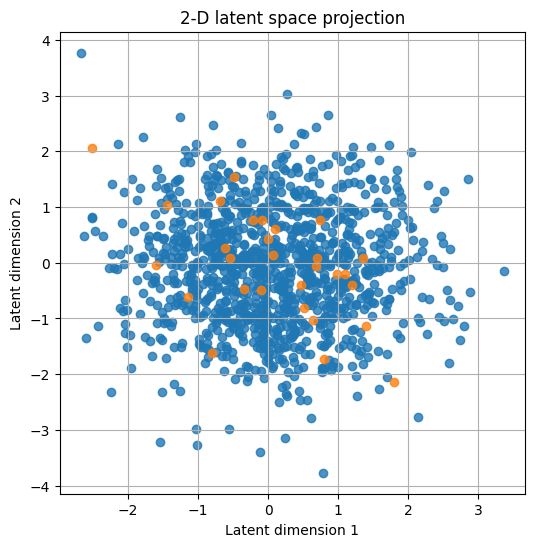

In [30]:
plot_x = x_train
plot_y = y_train
import matplotlib.pyplot as plt

latents = generate_latents(cvae, plot_x, plot_y)

fig, ax = plt.subplots(figsize=(6, 6))     # one figure, no sub-plots
for lab in np.unique(plot_y):                 # ➊ iterate once per class
	idx = plot_y == lab                       # ➋ boolean mask
	ax.scatter(latents[idx, 0], latents[idx, 1], label=f"Class {lab}", alpha=0.8) 
	ax.set_xlabel("Latent dimension 1")        # always label axes
ax.set_ylabel("Latent dimension 2")
ax.set_title("2-D latent space projection")
ax.grid(True)                              # optional helper grid
plt.show()

In [ ]:
# problem = NSGA_II_Filter(
# 	synthetic_features, synthetic_labels, 
# 	x_validation, y_validation,
# )
# algorithm = NSGA2(
# 	pop_size=500, 
# 	sampling=DiverseSampling(), 
# 	crossover=HUX(), 
# 	mutation=BitflipMutation(), 
# 	eliminate_duplicates=True
# )
# result = minimize(
# 	problem, 
# 	algorithm, 
# 	('n_gen', 100),
# 	save_history=False,
# )